# 文本分类

在本课中，我们通过抓取京东商场上面的评论形成我们的语料。然后，我们训练一个模型来对这些评论进行分类，分为正面的评论和负面的评论。

In [33]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [2]:
# 导入程序所需要的程序包

#抓取网页内容用的程序包
import json
import requests

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np


import torch.utils.data as Data	# 用于创建 DataLoader
import torch.nn as nn
%matplotlib inline

## 一、数据处理

### .数据预处理

In [7]:
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'

# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号

#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(correct_file, incorrect_file, is_filter = True):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储correct的 pair
    neg_sentences = [] #存储incorrect的pair
    with open(correct_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(correct_file, idx+1, len(all_words)))
    


    count = len(all_words)
    with open(bad_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            print(words)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)

st = sorted([(v[1], w) for w, v in diction.items()])
st


data/good.txt 包含 8089 行, 100839 个词.
['穿', '了', '几天', '就', '起毛', '了', '买', '亏了', '还有', '太薄', '了']
['话', '不', '多', '说', '你们', '自己', '看才', '穿', '一次']
['有图', '自己', '看', '就', '不能', '负点', '责任']
['穿', '了', '两天', '就', '起球', '了', '多', '的', '不想', '说', '的', '裤子', '这', '质量', '花钱买', '教训', '再也', '不', '在', '京东', '上', '买', '东西', '了']
['面料', '还', '可以', '就是', '这个', '开', '线', '问题', '我', '希望', '最好', '能', '完善', '第一次', '京东', '购物', '被', '坑', '了', '瞬间', '对', '京东', '购物', '失去', '的', '憧憬']
['穿', '上', '两天', '就', '起球', '了', '质量', '太差', '我', '可能', '买', '了', '条假', '裤子', '一次', '伤心', '的', '购物']
['质量', '太', '差', '根本', '不值', '针码', '那么', '打锁', '边线', '还是', '永', '的', '最', '便宜', '的', '丝线', '线头', '也', '剪', '的', '不', '干净', '很差', '的', '一次', '购物']
['这', '就是', '眼里', '的', '修身', '小脚', '裤', '逗我', '呢']
['这店', '就是', '骗人', '呢', '希望', '大家', '不要', '在', '上当受骗', '了', '我', '买回来', '才', '穿', '了', '两三天', '就', '起球', '了', '店家', '还', '说', '质量保证', '保证', '个', '屁', '要求', '退货', '也', '不', '退', '大家', '自己', '主意', '啊']
['干', '这', '什么', '裤子', '一百多', '才',

['差评', '差评', '买', '双鞋', '退货', '足足', '用', '了', '快', '半个', '月', '时间', '还', '发错', '货']
['质量', '太', '不好', '了', '虽然', '价位', '在', '这里', '摆着', '但是', '也', '太', '对不起', '良心', '了']
['这', '鞋子', '只能', '穿', '一', '星期', '的', '简称', '祝拜', '鞋', '请', '你们', '还', '买', '吗']
['0', '分']
['觉对', '差评', '一', '星期', '才', '收到', '还', '退', '不了', '货']
['不', '满意', '太', '不', '满意', '了', '鞋', '上面', '有点', '黑点', '差', '也', '差', '不', '掉', '码', '号', '也', '不准', '下次', '再也', '不买', '了']
['这鞋', '买', '的', '真', '差劲', '味道', '老大', '啦', '问', '他', '有没有', '味道', '还', '说', '没有', '骗人']
['妈', '的', '什么', '玩意', '鞋子', '小不说', '还', '快递', '巨慢', '差评', '必须', '差评', '跟', '它们', '协商', '还', '吊', '不', '建议', '大家', '在', '他家', '购买']
['快递', '慢死', '了', '都', '六七天', '才', '到', '我', '要', '退货', '还', '不', '叫', '我', '退', '都', '快', '气死我了']
['差评', '还', '没', '穿', '几天', '就', '开胶', '了', '不会', '在', '他家', '买', '了']
['鞋子', '都', '不', '看', '差评', '发货', '发了', '五天', '是', '在', '搞', '什么', '第一次', '遇到', '这种']
['你', '给', '我', '出来', '这', '鞋子', '发霉', '是', '什么', '鬼', '还有', '线头', '都', '没有', 

['垃圾', '货']
['骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '骗子', '垃圾', '骗子', '垃圾']
['垃圾']
['掉色']
['脱线']
['物流', '太慢', '了', '第八天', '才', '到']
['垃圾']
['垃圾']
['好好']
['不好']
['辣鸡']
['衣服', '上', '的', '印花', '都', '是', '模糊', '的', '衣服', '一股', '怪味', '洗', '都', '洗不掉', '看着', '衣服', '的', '款式', '喜欢', '才', '买', '的', '便宜', '没好', '货', '你', '这个', '根本', '就', '不能', '算', '衣服', '买回来', '就', '没', '穿过', '丢', '在', '一边', '理都', '不想', '理']
['衣服', '做工', '太', '差', '布料', '垃圾', '还有', '异味', '还脏', '尺码', '不', '均匀', '快递', '非常', '慢', '总之', '是', '垃圾', '中', '的', '战斗机']
['1']
['唉']
['颜色', '不', '对', '啊']
['差']
[]
['搓']
['垃圾', '颜色', '都', '不', '一样', '白', '的', '都', '是', '灰色', '的']
['差']
['买来', '后', '衣服', '穿着', '比较', '紧', '另外', '穿过', '一回', '衣服', '上', '就', '有', '了', '裂痕', '质量', '不敢恭维']
['这', '衣服', '太差', '了', '吧', '刚', '穿', '一天', '就', '起球', '那么', '厉害', '很', '不', '高兴']
['差评', '垃圾', '货', '收到', '领口', '脱线', '联系', '客服', '服务', '不好']
['太坑', '了', '好多', '黑点', '不', '满意']
['差评', '买', '的', '时间', '咨询', '回复',

['次品']
[]
['不行']
['不行']
['不好']
['垃圾']
['不好']
['差']
['衣服', '到', '了', '质量', '很差', '关键', '是', '新衣', '到', '了', '味道', '是', '臭', '的', '辣', '眼睛', '啊', '真心', '一星', '不想', '给', '啊', '拍照', '时', '发现', '领子', '已经', '发黄']
['衣服', '还', '没', '看', '买', '两件', '快递', '只有', '一个', '包裹', '居然', '收', '我', '两份', '快递费', '你', '分', '两个', '寄', '我', '还', '平衡点', 'hellip', ';']
['什么', '衣服', '拿', '回来', '一看', '就', '一个', '洞', '厂家', '做', '衣服', '没有', '验货', '员', '吗']
['穿', '了', '帅', '不帅']
['一个月', '才', '到', '我', '也', '不想', '说', '什么', '了']
['差评', '买来', '就', '烂', '了']
['和', '图片', '不', '符合', '说', '是', '修身', '的', '货到', '了', '以后', '不是', '修身', '的', '下次', '从', '这家', '买', '了', '肯爹', '的']
['质量', '超级', '的', '差', '超级', '的', '差', '太烂', '了']
['垃圾', '简直', '就是', '地摊货', '东西', '还要', '老子', '最差', '的', '一次', '网购']
['质量', '不好', '和', '图片', '上', '的', '不', '一样']
['布料', '太差', '了', '颜色', '也', '跟', '图片', '完全', '不', '和', '穿', '在', '身上', '痒痒', '的', '给', '个', '一星']
['可以', '但是', '速度', '太慢']
['衣服', '起毛', '不好', '穿', '好', '不', '舒服']
['码数', '偏小', '建议', '拍大', '一

['发货', '慢慢', '慢', '太薄', '了', '还', '说', '加厚', '加', 'JB', '这家', '店', '是', '靠', '忽悠', '人', '的', '一次', '过', '生意']
['衣服', '很', '满意', '质量', '不错', '不错', '的', '手感', '很', '好']
['质量', '不错', '卖家', '态度', '好', '卖家', '发货', '速度', '快']
['做工', '精细', '面料', '手感', '柔软', '颜色', '没有', '色差']
['还', '不错', '老公', '很', '喜欢', '以后', '还会', '关注', '的']
['非常', '不错', '的', '衣服', '大小', '也', '刚', '合身']
['衣服', '不错', '穿着', '舒服', '尺码', '大小', '正好', '布料', '的', '手感', '很', '好']
['质量', '不错', '大小', '刚好', '老公', '很', '喜欢']
['外套', '款式', '和', '颜色', '都', '好看', '面料', '好', '穿着', '合适', '老公', '很', '喜欢', '哈']
['衣服', '颜色', '差别', '太大', '了', '真让人', '失望', '让', '我', '都', '不想', '在', '网上', '购物', '了']
['衣服', '好看', '质量', '不错', '物流', '快全', '五星']
['样式', '很', '好', '面料', '柔软', '穿着', '很', '舒服']
['衣服', '质量', '很', '不错', '呢', '穿着', '很', '舒服']
['一点', '不好', '穿', '上', '不', '暖和', '价格', '高', '网上', '看', '的', '与', '送来', '的', '货', '差别', '太', '大']
['质量', '不好', '右', '口袋', '拉链', '没用', '几天', '就', '卡住', '怎么', '也', '打不开']
['宝贝', '质量', '不错', '尺码', '大小', '合适']
['质量', '很', '好

['很', '失望', '的', '一次', '购物']
['上当', '不要', '买', '掉色', '一点', '也', '不好']
['狗屁']
['大家', '千万别', '买', '袖子', '太', '长']
['有点', '大', '了']
['下次', '不会', '再来', '了']
['做工', '好差', '衣服', '烫', '都', '没有', '烫', '平整', '这', '是', '我', '在', '京东', '上', '最差', '的', '一次', '购物']
['垃圾', '货', '衣服', '真', '不好', '穿']
['好大', '啊', '我', '要', '的', '是', 'm', '其实', '至少', '是', 'xl', '以上', '又', '宽容', '太', '后悔', '了', '怀疑', '不是', '正品', '快', '过年', '了', '懒得', '退货']
['衣服', '比', '想象', '中', '呢', '薄', '多', '了', '一点', '都', '不', '暖和']
['衣服', '都', '没', '见到', '就', '已', '签收', '了', '而且', '发货', '到', '至今', '都', '半个', '月', '了', '这家', '店铺', '我', '也', '是', '醉', '了']
['衣服', '不怎么', '好']
['东西', '不怎么样', '样式', '和', '看', '的', '不', '一样', '袖子', '口肥']
['太薄']
['纯', '假货', '且不说', '实物', '与', '图片', '不符', '而且', '做工', '太', '差', '到处', '是', '线头', '粗糙', '无比', '绉', '绉', '巴巴', '连', '地摊货', '都', '不如', '呼吁', '大家', '不要', '上当']
['尺码', '太大太大']
['来', '大家', '都', '看看', '这', '什么', '玩意', '做工', '我', '真是', '无力', '吐槽', '请问', '店家', '是', '买不起', '熨', '衣服', '的', '熨机', '吗', '还有', '再

[(1, '---'),
 (1, '------'),
 (1, '000000000'),
 (1, '0000000000000000'),
 (1, '00000000000000000'),
 (1, '0000000000000000000000'),
 (1, '000000000000000000000000000'),
 (1, '00000000000000000000000000000000000000000000000'),
 (1, '1006'),
 (1, '111'),
 (1, '1111111'),
 (1, '11111111111'),
 (1, '11111111111111'),
 (1, '111111111111111111111111'),
 (1, '11111111111111111111111111111'),
 (1, '111111111111111111111111111111111'),
 (1, '1111111111111111111111111111111111111111111'),
 (1, '115'),
 (1, '122'),
 (1, '12315'),
 (1, '123456'),
 (1, '1255888'),
 (1, '128'),
 (1, '130'),
 (1, '136'),
 (1, '138'),
 (1, '15548'),
 (1, '158105'),
 (1, '160'),
 (1, '16067cm'),
 (1, '165140'),
 (1, '165cm'),
 (1, '166cm68kgxl'),
 (1, '16860'),
 (1, '170CM55'),
 (1, '170M'),
 (1, '170cm75kg'),
 (1, '171819202122'),
 (1, '172'),
 (1, '172153'),
 (1, '175cm'),
 (1, '1805'),
 (1, '180xxl'),
 (1, '183'),
 (1, '185'),
 (1, '1852XL'),
 (1, '185XXL'),
 (1, '185mm'),
 (1, '200000000'),
 (1, '20161218'),
 (1, 

In [5]:
diction

{'这': [0, 532],
 '应该': [1, 80],
 '是': [2, 1311],
 '我': [3, 1770],
 '在': [4, 513],
 '网上': [5, 113],
 '买': [6, 1655],
 '裤子': [7, 165],
 '最': [8, 76],
 '喜欢': [9, 1472],
 '的': [10, 7121],
 '一条': [11, 6],
 '太赞': [12, 2],
 '不错': [13, 5242],
 '穿着': [14, 1005],
 '舒服': [15, 1864],
 '还': [16, 1814],
 '不贵': [17, 33],
 '挺': [18, 839],
 '好': [19, 3891],
 '很': [20, 7200],
 '洗过': [21, 9],
 '也': [22, 2853],
 '不缩水': [23, 10],
 '显': [24, 13],
 '瘦点': [25, 3],
 '赞': [26, 151],
 '今天': [27, 71],
 '第一次': [28, 138],
 '穿刚': [29, 1],
 '坐下': [30, 1],
 '就': [31, 1251],
 '发现': [32, 60],
 '裤边': [33, 1],
 '都': [34, 1187],
 '开线': [35, 25],
 '了': [36, 5204],
 '从': [37, 33],
 '没有': [38, 554],
 '买过': [39, 18],
 '这么': [40, 216],
 '结实': [41, 11],
 '衣服': [42, 2797],
 '太': [43, 459],
 '耐穿': [44, 12],
 '早上': [45, 2],
 '穿': [46, 2679],
 '到': [47, 449],
 '公司': [48, 62],
 '就要': [49, 12],
 '走光': [50, 1],
 '可是': [51, 15],
 '零下': [52, 1],
 '五度': [53, 1],
 '天气': [54, 16],
 '啊': [55, 357],
 '滴天': [56, 1],
 '老公': [57, 605],
 '大小': [5

## 二、词袋模型

词袋模型实际上是一种对文本进行向量化的手段，通过统计出词表上的每个单词出现频率，从而将一篇文章向量化

### 1. 训练数据准备

In [8]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)
    

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

### 2. 模型定义

In [9]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

### 3. 训练模型

In [10]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

/home/daniel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


第0轮，训练损失：0.52, 校验损失：0.78, 校验准确率: 0.35
第0轮，训练损失：0.36, 校验损失：0.31, 校验准确率: 0.90
第0轮，训练损失：0.34, 校验损失：0.29, 校验准确率: 0.91
第0轮，训练损失：0.32, 校验损失：0.29, 校验准确率: 0.91
第1轮，训练损失：0.31, 校验损失：0.31, 校验准确率: 0.91
第1轮，训练损失：0.29, 校验损失：0.29, 校验准确率: 0.91
第1轮，训练损失：0.29, 校验损失：0.29, 校验准确率: 0.92
第1轮，训练损失：0.28, 校验损失：0.30, 校验准确率: 0.91
第2轮，训练损失：0.27, 校验损失：0.31, 校验准确率: 0.91
第2轮，训练损失：0.27, 校验损失：0.29, 校验准确率: 0.91
第2轮，训练损失：0.26, 校验损失：0.30, 校验准确率: 0.92
第2轮，训练损失：0.26, 校验损失：0.31, 校验准确率: 0.91
第3轮，训练损失：0.25, 校验损失：0.32, 校验准确率: 0.91
第3轮，训练损失：0.25, 校验损失：0.30, 校验准确率: 0.92
第3轮，训练损失：0.25, 校验损失：0.31, 校验准确率: 0.92
第3轮，训练损失：0.24, 校验损失：0.32, 校验准确率: 0.92
第4轮，训练损失：0.24, 校验损失：0.33, 校验准确率: 0.91
第4轮，训练损失：0.24, 校验损失：0.31, 校验准确率: 0.91
第4轮，训练损失：0.24, 校验损失：0.32, 校验准确率: 0.92
第4轮，训练损失：0.23, 校验损失：0.33, 校验准确率: 0.92
第5轮，训练损失：0.23, 校验损失：0.35, 校验准确率: 0.91
第5轮，训练损失：0.23, 校验损失：0.32, 校验准确率: 0.91
第5轮，训练损失：0.23, 校验损失：0.33, 校验准确率: 0.91
第5轮，训练损失：0.23, 校验损失：0.34, 校验准确率: 0.91
第6轮，训练损失：0.22, 校验损失：0.36, 校验准确率: 0.91
第6轮，训练损失：0.22, 校验损失：0.33, 校验准确率: 0.91
第6轮，训练损失：0.2

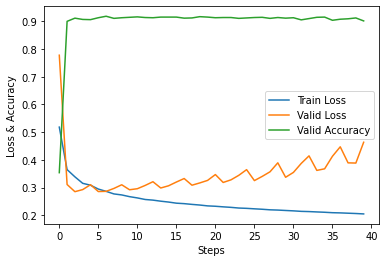

In [11]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [107]:
# 保存、提取模型（为展示用）
#torch.save(model,'bow.mdl')
#model = torch.load('bow.mdl')

In [15]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

0.906369915579432

### 4. 解剖神经网络

接下来，看一看每一个神经元都在检测什么模式；

通过这种分析，可能看到神经网络在测试集上判断错误的数据上出错的原因

#### 1). 查看每一层的模式

In [12]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=7135, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=None)
)>

Text(0, 0.5, 'Weights')

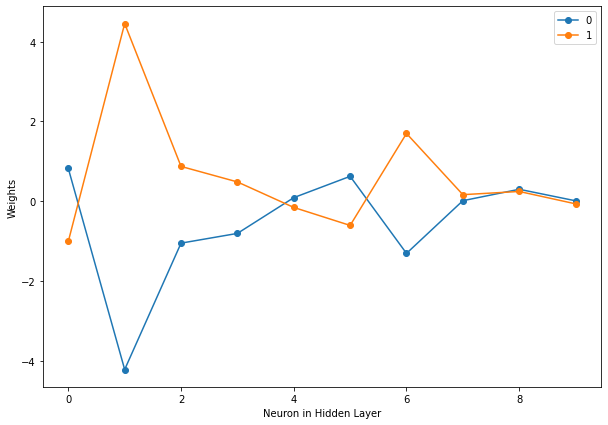

In [17]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

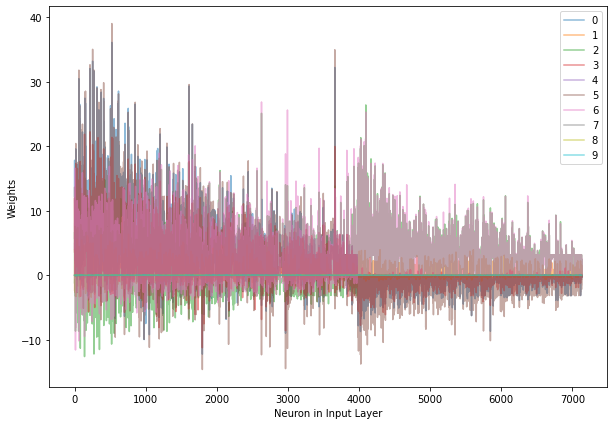

In [18]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [19]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)




第0个神经元
max:
YY
耐心
nbsp
划算
完全一致
亲身
quot
热情
努力
质感
我用
亲身经历
棒棒
男朋友
包装
大众化
五分
老朋友
期望值
min:
垃圾
上当
不想
差评
差劲
单大
很差
失败
没收
发错
不如
太差
不值
差
字烂
慎重
不透气
月
丢
好差


第1个神经元
max:
很大
咋
差评
码
大家
有
等
都
一
瑕疵
差距
越
相差
呀
来
小
想想
居然
不要
min:
可要
呵呵
质量
很
朋友
好评
的
实惠
薄
胶水
优惠
拥有
速度
适合
这
来说
合身
老板
问
很快


第2个神经元
max:
地摊货
严重
发错
不如
差劲
差差
竟然
一个月
好差
死
骗人
玩意
粗糙
丢
破
很差
要死
前面
却
min:
力
完全一致
试穿
谢谢
还行
继续
超值
正合适
还会来
精细
合脚
不错
老公
广西南宁
可
当时
很漂亮
购
试
物超所值


第3个神经元
max:
划算
力
YY
刚刚
没得说
耐心
nbsp
男朋友
包装
必须
质感
试穿
下手
很快
quot
不贵
期望值
试
这么
min:
垃圾
差评
不值
差劲
不透气
严重
哎
骗
135
竟然
烂货
一星
差
最差
坑人
无语
骗人
旗舰店
进
醉


第4个神经元
max:
用来
包好
bdhdiifjdjdhdhdueiejf
关顾
超乎
不换
表
怪不得
我次
五十几
无理取闹
太多人
衣衣
长算
重了
抢眼
中差
但是
身
min:
还
可以
紧身服
帮买
最后
晕
价能
不值
太大
实
黄
73120
花纹
大面积
东
大换
≦
冒
不进
拆


第5个神经元
max:
YY
耐心
nbsp
划算
完全一致
亲身
大众化
男朋友
quot
热情
亲身经历
我用
五分
棒棒
努力
质感
老朋友
试
期望值
min:
垃圾
差评
发错
差劲
严重
骗人
退
不想
扔
千万
太大
最差
单大
上当
烂
很差
太差
洞
不符
不值


第6个神经元
max:
严重
退
地摊货
差差
发错
不如
差劲
竟然
星期
破
找
一个月
差评
死
很差
骗人
发
丢
粗糙
min:
不错
合适
力
好
实惠
正合适
没得说
物超所值
挺不错
试试
惊喜
试穿
值得称赞
人暖心
物有所值
广西南宁
外观
不差
挺
很漂亮


第7个神经元
max:
也

#### 2. 寻找判断错误的原因

In [20]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

/home/daniel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [21]:
# 逐个查看出错的句子是什么
idx = 1
print(sentences[sent_indices[idx]], targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

['穿', '在', '身上', '刚刚', '好', '质量', '也', '不错'] 1
['在', '不错', '好', '也', '穿', '质量', '刚刚', '身上']


In [22]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[ 7.05835102e+00],
       [-2.94048754e-01],
       [ 1.14033347e+00],
       [ 6.97529646e+00],
       [ 1.60407706e-03],
       [ 5.84019464e+00],
       [ 1.92995161e+00],
       [-2.94683277e-03],
       [-7.77684729e-03],
       [-1.82166889e-02]])

In [23]:
# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]]

array([13.424068 ,  0.0875147,  6.9428573,  7.2432547,  4.6870203,
        0.5094486, 13.03425  , 10.538394 ], dtype=float32)

## 三、RNN模型

我们分别比较了两种RNN模型，一个是普通的RNN模型，另一个是LSTM。

本单元的主要目的是了解RNN模型如何实现，以及考察它们在测试数据集上的分类准确度

### 1. 普通RNN模型

In [13]:
# 需要重新数据预处理，主要是要加上标点符号，它对于RNN起到重要作用
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'
# 生成正样例和反样例，以及词典，很有趣的是，词典中的词语竟然比不考虑标点符号的时候少了（要知道标点也是被当作一个单词的），
# 主要原因应该是总的分词出来的数量变少了。当去掉标点符号以后，有很多字的组合被当作了单词处理了。
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, False)

data/good.txt 包含 8089 行, 136359 个词.
['穿', '了', '几天', '就', '起毛', '了', '，', '买', '亏了', '，', '还有', '太薄', '了', '！', '\n']
['话', '不', '多', '说', '你们', '自己', '看才', '穿', '一次', '\n']
['有图', '自己', '看', ' ', '就', '不能', '负点', '责任', '\n']
['穿', '了', '两天', '就', '起球', '了', '，', '多', '的', '不想', '说', '。', '*', '*', '的', '裤子', '这', '质量', '。', '花钱买', '教训', '，', '再也', '不', '在', '京东', '上', '买', '东西', '了', '。', '\n']
['面料', '还', '可以', '，', '就是', '这个', '开', '线', '问题', '，', '我', '希望', '最好', '能', '完善', '，', '第一次', '京东', '购物', '被', '坑', '了', '，', '瞬间', '对', '京东', '购物', '失去', '的', '憧憬', '\n']
['穿', '上', '两天', '就', '起球', '了', '，', '质量', '太', '差', '，', '我', '可能', '买', '了', '条假', '裤子', '。', '一次', '伤心', '的', '购物', '\n']
['质量', '太', '差', '根本', '不值', '*', '。', '针码', '那么', '打', '，', '锁', '边线', '还是', '永', '的', '最', '便宜', '的', '丝线', '。', '线头', '也', '剪', '的', '不', '干净', '。', '很差', '的', '一次', '购物', '\n']
['这', '就是', '眼里', '的', '修身', '小脚', '裤', '？', '逗我', '呢', '？', '\n']
['这店', '就是', '骗人', '呢', '，', '希望', '大家', '不要', '在', '

['不', '耐穿', '\n']
['一般般', '\n']
['还好', '吧', '\n']
['死难', '看', '\n']
['还', '可以', '\n']
['我', '一直', '都', '很', '信赖', '京东', '，', '手机', 'app', '就算', '换', '了', '手机', '都', '一直', '在', '手机', '上', '，', '结果', '这次', '买', '东西', '搞', '得', '我', '很', '火', '，', '一', '开始', '买', '的', '时候', '问', '卖家', '，', '能', '不能', '改', '地址', '，', '他', '说', '可以', '，', '我', '也', '只是', '试试', '，', '是', '买', '给', '家里', '的', '弟弟', '的', '，', '你', '不行', '的话', '大不了', '我', '自己', '发回去', '，', '反正', '也', '就', '*', '事', '！', '结果', '发到', '我', '这来', '，', '跟', '客服', '联系', '一', '开始', '否认', '，', '要', '我', '截图', '给', '他', '，', '截', '了', '，', '之后', '说', '，', '您', '自己', '再', '寄过去', '，', '这是', '你们', '的', '错', '，', '你们', '就是', '这样', '对', '我们', '买家', '的', '吗', '，', '客服', '态度', '差', '的', '离谱', '！', '！', '！', '！', '！', '！', '！', '！', '\n']
['上当', '了', '\n']
['不行', '\n']
['。', '。', '\n']
['一般', '\n']
['水货', '\n']
['倒霉', '\n']
['坑', '呐', '\n']
['垃圾', '\n']
['不行', '\n']
['我', '不', '知道', '别人', '下单', '时', '是', '什么', '时候', '发', '的', '货', '，', '三四天', '

['掉', '毛', '很', '厉害', '，', '身上', '一层', '，', '15', '块', '的', '地摊货', '也', '要', '比', '这个', '好', '\n']
['掉', '毛', '很', '厉害', '，', '身上', '一层', '，', '15', '块', '的', '地摊货', '也', '比', '这个', '好', '\n']
['太薄', '了', '，', '跟', '秋衣', '没', '啥', '区别', '\n']
['不好', '一点', '都', '不好', '。', ' ', '我', '一次', '都', '没有', '穿', '。', '丢', '了', '\n']
['恶心', '的', '商家', '，', '颜色', '严重', '偏色', '，', '不要', '买', '了', '。', '买', '了', '恶心', '\n']
['什么', 'M', '码', '，', '穿', '起来', '跟', '以前', '买', '的', '还', '长', ' ', '算', 'L', '了', '\n']
['价格便宜', '。', '心动', '就', '行动', '，', '你', '要', '你', '也', '来', '\n']
['大小', '合适', '，', '还', '能', '穿', '，', '色差', '也', '有点', '，', '洗衣', '脱色', '太大', '了', '\n']
['好', '小', '啊', '，', '根本', '不是', '给', '170', '穿', '的', '，', '太紧', '了', '，', '不', '舒服', '\n']
['布料', '真', '垃圾', '，', '买', '了', '回来', '穿起', '痒', '死', '人', '。', '垃圾', '\n']
['能', '给', '负星', '么', '，', '我', '都', '没收', '到货', '，', '这', '还', '定单', '完成', '了', '？', '\n']
['咖啡色', '变成', '黑色', '跟', '内衣', '似的', '不会', '在', '爱', '了', '\n']
['就', '这个', '价

['我', '一米', '六八', '的', '身高', ' ', '这件', '衣服', '有点', '大', ' ', '再有', ' ', '这', '不是', '保暖', '的', ' ', '郁闷', ' ', '太薄', '了', ' ', '\n']
['质量', '很差', '，', '起毛', '球', '。', '下次', '不买', '了', '\n']
['一般', ' ', ' ', ' ', ' ', '！', '\n']
['一', '\n']
['质量', '不杂', '滴', '\n']
['垃圾', '，', '穿', '一天', '起', '一身', '红', '点', '，', '痒', '死', '了', '\n']
['便宜', '无好', '货', '\n']
['太', '垃圾', '了', '，', '买来', '就', '开', '袖子', '的', '线', '还', '起球', '\n']
['差差', '差差', '差差', '，', '买来', '丢掉', '，', '穿出去', '丢脸', '死', '了', '\n']
['一般', '，', '跟', '价格', '一样', '\n']
['很差', ' ', ' ', '不', '符合', '\n']
['一般', '\n']
['一般', '\n']
['\n']
['东西', '不好', '，', '不过', '便宜', '，', '也', '不想', '穿', '了', '。', '扔', '就', '扔', '了', '\n']
['就是', '太吸', '毛', '了', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '便宜', '没好', '东西', ' ', ' ', '?', '\n']
['完全', '不能', '用', '11111111111111', '\n']
['半个', '月', '了', '，', '衣服', '都', '没', '看到', '，', '66666666', '，', '\n']
['还', '行', '，', '可以', '啊', '\n']
['邮递员', '服务态度', '不好', '！', '！', '！', '！', '！', '\n']
['不行', '\n']
['

['同时', '买', '了', '2', '件', '衣服', '！', '黑色', '和', '绿色', '的', '都', '是', 'XXXL', '的', '码', '！', '黑色', '的', '衣服', '小', '的', '就', '根本', '穿', '不', '上', '，', '绿色', '的', '却', '穿', '上', '后', '还', '有些', '大', ' ', '真不知道', '你家', '衣服', '这码', '是', '咋', '搭配', '的', '！', '极度', '无语', '中', '...', '在', '京东', '买', '了', '好多', '东西', '了', '，', '这次', '购物', '是', '最', '郁闷', '的', '，', '东西', '不', '贵', '，', '但是', '很', '填堵', '！', '看来', '真的', '不能', '再', '第三方', '买', '东西', '了', '！', '\n']
['同时', '买', '了', '2', '件', '衣服', '！', '黑色', '和', '绿色', '的', '都', '是', 'XXXL', '的', '码', '！', '黑色', '的', '衣服', '小', '的', '就', '根本', '穿', '不', '上', '，', '绿色', '的', '却', '穿', '上', '后', '还', '有些', '大', ' ', '真不知道', '你家', '衣服', '这码', '是', '咋', '搭配', '的', '！', '极度', '无语', '中', '...', '\n']
['衣服', '号', '不准', '头', '，', '太', '大', '，', '而且', '衣服', '都', '开线', '了', '\n']
['第一次', '买', '的', '衣服', '就是', '坏', '的', '，', '邮', '过去', '换', '，', '说', '的', '退', '给', '我', '运费', '到', '现在', '都还没', '退', '，', '我', '也', '不', '*', '*', '*', '，', '只是', '心里', '不', '

In [14]:
# 重新准备数据，输入给RNN
# 与词袋模型不同的是。每一个句子在词袋模型中都被表示为了固定长度的向量，其中长度为字典的尺寸
# 在RNN中，每一个句子就是被单独当成词语的序列来处理的，因此序列的长度是与句子等长的

dataset = []
labels = []
sentences = []

# 正例集合
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            # 注意将每个词编码
            new_sentence.append(word2index(l, diction))
    #每一个句子都是一个不等长的整数序列
    dataset.append(new_sentence)
    labels.append(0)
    sentences.append(sentence)

# 反例集合
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(new_sentence)
    labels.append(1)
    sentences.append(sentence)

# 重新对数据洗牌，构造数据集合
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

# 校验集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]

# 测试集
test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


In [15]:
# 一个手动实现的RNN模型

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # 一个embedding层
        self.embed = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.i2h = nn.Linear(2 * hidden_size, hidden_size)
        # 隐含层到输出层的链接
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        
        # 先进行embedding层的计算，它可以把一个数或者数列，映射成一个向量或一组向量
        # input尺寸：seq_length, 1
        x = self.embed(input)
        # x尺寸：hidden_size
        
        # 将输入和隐含层的输出（hidden）耦合在一起构成了后续的输入
        combined = torch.cat((x, hidden), 1)
        # combined尺寸：2*hidden_size
        #
        # 从输入到隐含层的计算
        hidden = self.i2h(combined)
        # combined尺寸：hidden_size
        
        # 从隐含层到输出层的运算
        output = self.i2o(hidden)
        # output尺寸：output_size
        
        # softmax函数
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是：batch_size, hidden_size
        return torch.zeros(1, self.hidden_size)



In [ ]:
# 开始训练这个RNN，10个隐含层单元
rnn = RNN(len(diction), 10, 2)

# 交叉熵评价函数
cost = torch.nn.NLLLoss()

# Adam优化器
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.001)
records = []

# 学习周期10次
losses = []

#patience = 2 # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
#early_stopping = EarlyStopping(patience, verbose=True)

for epoch in range(3):
    
    #model.train()
    
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
        #x尺寸：seq_length（序列的长度）
        y = torch.tensor(np.array([y]), dtype = torch.long)
        #x尺寸：batch_size = 1,1
        optimizer.zero_grad()
        
        #初始化隐含层单元全为0
        hidden = rnn.initHidden()
        # hidden尺寸：batch_size = 1, hidden_size
        
        #手动实现RNN的时间步循环，x的长度就是总的循环时间步，因为要把x中的输入句子全部读取完毕
        for s in range(x.size()[0]):
            output, hidden = rnn(x[s], hidden)
        
        #校验函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        loss.backward()
        # 开始优化
        optimizer.step()
        if i % 3000 == 0:
            # 每间隔3000步来一次校验集上面的计算
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                hidden = rnn.initHidden()
                for s in range(x.size()[0]):
                    output, hidden = rnn(x[s], hidden)
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())              
                
                
                
            # 计算准确度
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


第0轮，训练损失：0.74, 测试损失：0.69, 测试准确率: 0.58
第0轮，训练损失：0.58, 测试损失：0.58, 测试准确率: 0.75
第0轮，训练损失：0.51, 测试损失：0.43, 测试准确率: 0.82
第0轮，训练损失：0.46, 测试损失：0.41, 测试准确率: 0.85
第1轮，训练损失：0.44, 测试损失：0.35, 测试准确率: 0.87
第1轮，训练损失：0.43, 测试损失：0.35, 测试准确率: 0.88
第1轮，训练损失：0.41, 测试损失：0.34, 测试准确率: 0.88
第1轮，训练损失：0.39, 测试损失：0.38, 测试准确率: 0.86
第2轮，训练损失：0.38, 测试损失：0.32, 测试准确率: 0.88
第2轮，训练损失：0.38, 测试损失：0.31, 测试准确率: 0.89


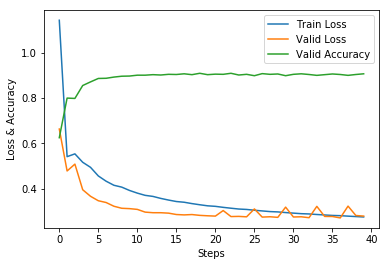

In [70]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [78]:
#在测试集上运行，并计算准确率
vals = [] #记录准确率所用列表
rights = []
#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = rnn.initHidden()
    for s in range(x.size()[0]):
        output, hidden = rnn(x[s], hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/anaconda3/envs/pytorch1.0/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.9164133738601824

In [76]:
#保存、加载模型（为讲解用）
#torch.save(rnn, 'rnn.mdl')
#rnn = torch.load('rnn.mdl')

/Users/jake/anaconda/envs/learning_pytorch/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
rnn.named_parameters

## LSTM网络

普通RNN的效果并不好，我们尝试利用改进型的RNN，即LSTM。LSTM与RNN最大的区别就是在于每个神经元中多增加了3个控制门：遗忘门、输入门和输出门. 另外，在每个隐含层神经元中，LSTM多了一个cell的状态，起到了记忆的作用。

这就使得LSTM可以记忆更长时间的Pattern

In [79]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：一个embedding层，将输入的任意一个单词映射为一个向量
        # 一个LSTM隐含层，共有hidden_size个LSTM神经元
        # 一个全链接层，外接一个softmax输出
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, 2)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        
        #input尺寸: seq_length
        #词向量嵌入
        embedded = self.embedding(input)
        #embedded尺寸: seq_length, hidden_size
        
        #PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        #第二个维度才是batch_size，所以需要对embedded变形
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
        #embedded尺寸: seq_length, batch_size = 1, hidden_size
    
        #调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm(embedded, hidden)
        #output尺寸: seq_length, batch_size = 1, hidden_size
        #hidden尺寸: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]
        #output尺寸: batch_size = 1, hidden_size

        #全链接层
        out = self.fc(output)
        #out尺寸: batch_size = 1, output_size
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        
        # 对隐单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return (hidden, cell)



In [86]:
# 开始训练LSTM网络

# 构造一个LSTM网络的实例
lstm = LSTMNetwork(len(diction), 10, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 开始训练，一共5个epoch，否则容易过拟合
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.LongTensor(x).unsqueeze(1)
        #x尺寸：seq_length，序列的长度
        y = torch.LongTensor([y])
        #y尺寸：batch_size = 1, 1
        optimizer.zero_grad()
        
        #初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        #hidden: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        #它自动会根据数据的维度计算若干时间步
        output = lstm(x, hidden)
        #output尺寸: batch_size = 1, output_size
        
        #损失函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.LongTensor(x).unsqueeze(1)
                y = torch.LongTensor(np.array([y]))
                hidden = lstm.initHidden()
                output = lstm(x, hidden)
                #计算校验数据集上的分类准确度
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

/anaconda3/envs/pytorch1.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


第0轮，训练损失：0.89, 测试损失：0.66, 测试准确率: 0.62
第0轮，训练损失：0.51, 测试损失：0.38, 测试准确率: 0.85
第0轮，训练损失：0.45, 测试损失：0.35, 测试准确率: 0.87
第0轮，训练损失：0.42, 测试损失：0.33, 测试准确率: 0.88
第1轮，训练损失：0.41, 测试损失：0.31, 测试准确率: 0.89
第1轮，训练损失：0.39, 测试损失：0.30, 测试准确率: 0.89
第1轮，训练损失：0.37, 测试损失：0.30, 测试准确率: 0.90
第1轮，训练损失：0.36, 测试损失：0.28, 测试准确率: 0.90
第2轮，训练损失：0.36, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.34, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.34, 测试损失：0.28, 测试准确率: 0.90
第2轮，训练损失：0.33, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.33, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.32, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.31, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.31, 测试损失：0.27, 测试准确率: 0.91
第4轮，训练损失：0.30, 测试损失：0.27, 测试准确率: 0.91
第4轮，训练损失：0.30, 测试损失：0.26, 测试准确率: 0.91
第4轮，训练损失：0.29, 测试损失：0.26, 测试准确率: 0.91
第4轮，训练损失：0.29, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.29, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.27, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.2

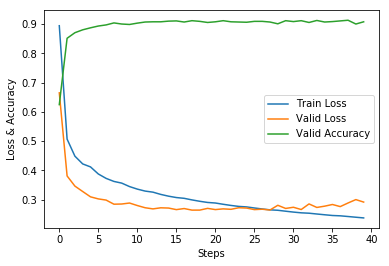

In [87]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [89]:
#在测试集上计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = lstm.initHidden()
    output = lstm(x, hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/anaconda3/envs/pytorch1.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.9050151975683891

In [99]:
#保存、加载模型（为讲解用）
#torch.save(lstm, 'lstm.mdl')
#rnn = torch.load('rnn.mdl')

/Users/jake/anaconda/envs/learning_pytorch/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
